In [18]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from PIL import ImageOps
import random
import torch.functional as F


import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

import numpy as np

# device = "cuda"
device= "mps"

In [19]:
class Solarization(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p):
        self.p = p

    # def __call__(self, img):
    #     if random.random() < self.p:
    #         img = transforms.ToPILImage()(img)
    #         return transforms.ToTensor()(ImageOps.solarize(img))
    #     else:
    #         return img
        
    def __call__(self, img_batch):
        if img_batch.dim()> 3:
            for img in img_batch:
                if random.random() < self.p:
                    img = transforms.ToPILImage()(img)
                    img = transforms.ToTensor()(ImageOps.solarize(img))
            return img_batch
        else:
            if random.random() < self.p:
                img = transforms.ToPILImage()(img)
                img = transforms.ToTensor()(ImageOps.solarize(img))
            return img_batch

# Dataset : Fashion MNIST

In [20]:
train_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64, shuffle=False)


def load_data(batch_size):
    train_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
    )

    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dl, test_dl

In [21]:
dummy = next(iter(train_dl))[0]

In [22]:
# plot 3x3 images in train set

def plot(images, labels, names):
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(names[labels[i].item()], fontsize=14)

    plt.show()

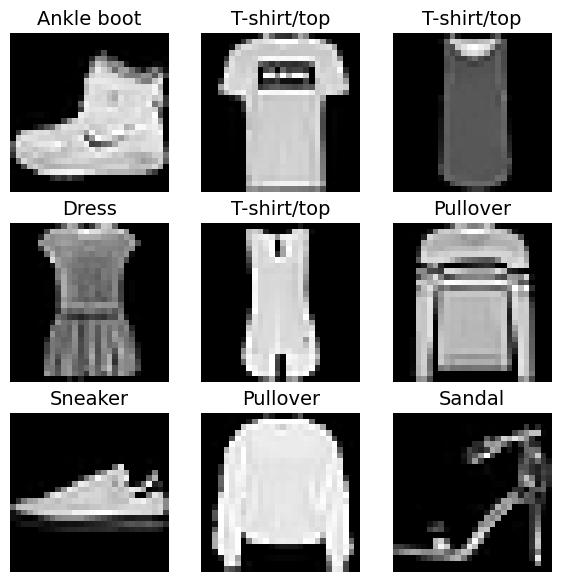

In [23]:
plot(images=train_data.data[:9], labels=train_data.targets[:9], names=train_data.classes)

# 1 - Construction du modèle

Le modèle est un ViT. Réimplémentons donc les ViT

In [24]:
class MSA(nn.Module):
    """ Implement multi-headed self-attention."""
    def __init__(self, dim_embedding, n_heads, dh=None) -> None:
        super().__init__()
        self.dim_embedding = dim_embedding
        self.n_heads = n_heads
        self.dh = dh or dim_embedding // n_heads
        self.qkv = nn.Linear(dim_embedding, 3 * (n_heads * self.dh))
        self.merge = nn.Linear(n_heads * self.dh, dim_embedding)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        
        q = q.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        
        A = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.dh, dtype=torch.float32)), dim=-1)
        out = torch.matmul(A, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        return self.merge(out)

class MLP(nn.Module):
    def __init__(self, dim_embedding) -> None:
        super().__init__()
        self.fc1 = nn.Linear(dim_embedding, 4*dim_embedding)
        self.fc2 = nn.Linear(4*dim_embedding, dim_embedding)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)



class Block(nn.Module):
    def __init__(self, dim_embedding, n_heads, dh=None):
        super().__init__()
        self.MSAH = MSA(dim_embedding, n_heads, dh)
        self.MLP = MLP(dim_embedding)
        self.layer_norm1 = nn.LayerNorm(dim_embedding)
        self.layer_norm2 = nn.LayerNorm(dim_embedding)

    def forward(self, x):
        x = self.layer_norm1(x)
        x = x + self.MSAH(x)
        x = self.layer_norm2(x)
        x = self.MLP(x) + x
        return x

class PatchEmbed(nn.Module):

    def __init__(self, dim_embedding, patch_size, num_patches=None, channels = 1):
        super().__init__()
        num_patches = num_patches or (28 // patch_size)**2
        self.conv = nn.Conv2d(channels, dim_embedding, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim_embedding))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim_embedding))

    def forward(self, x):
        B, C, H, W = x.shape
        x = torch.flatten(self.conv(x), start_dim = 2).permute(0, 2, 1)
        
        cls = self.cls_token.repeat(B, 1, 1)
        pos_embedding = self.pos_embedding.repeat(B, 1, 1)

        x = torch.cat([cls, x], dim=1) + pos_embedding
        return x
    
    # def interpolate_pos_encoding(self, x, w, h):
    #     npatch = x.shape[1] - 1
    #     N = self.pos_embed.shape[1] - 1
    #     if npatch == N and w == h:
    #         return self.pos_embed
    #     class_pos_embed = self.pos_embed[:, 0]
    #     patch_pos_embed = self.pos_embed[:, 1:]
    #     dim = x.shape[-1]
    #     w0 = w // self.patch_embed.patch_size
    #     h0 = h // self.patch_embed.patch_size
    #     # we add a small number to avoid floating point error in the interpolation
    #     # see discussion at https://github.com/facebookresearch/dino/issues/8
    #     w0, h0 = w0 + 0.1, h0 + 0.1
    #     patch_pos_embed = nn.functional.interpolate(
    #         patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
    #         scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
    #         mode='bicubic',
    #     )
    #     assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
    #     patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    #     return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    
class ProjectionHead(nn.Module):
    def __init__(self, dim_embedding, hidden_dim, num_classes):
        super().__init__()
        self.MLP = nn.Sequential(nn.LayerNorm(dim_embedding),
                                 nn.Linear(dim_embedding, hidden_dim), 
                                 nn.GELU(), 
                                #  nn.Linear(hidden_dim, hidden_dim),
                                #  nn.GELU()
                                 )
        self.last_layer= nn.utils.weight_norm(nn.Linear(hidden_dim, num_classes, bias=False))
        self.last_layer.weight_g.data.fill_(1)
    
    def forward(self, x):
        x = self.MLP(x)
        return self.last_layer(x)


In [25]:
class VisionTransformer(nn.Module):
    def __init__(self, dim_embedding, n_heads, patch_size, n_blocks, n_hidden, n_out, dh=None, num_patches=None, channels=1):
        super().__init__()
        self.embedding = PatchEmbed(dim_embedding, patch_size, num_patches, channels)
        self.blocks = nn.Sequential(*nn.ModuleList([Block(dim_embedding, n_heads, dh) for _ in range(n_blocks)]))
        self.projection_head = ProjectionHead(dim_embedding, n_hidden, n_out)

    def forward(self, x):
        X = self.embedding(x)
        X = self.blocks(X)
        return self.projection_head(X[:, 0])
        
    def embed(self, x):
        return self.embedding(x)

    def extract_features(self, x):
        return self.blocks(self.embedding(x))
    
    @property
    def extract_DINO(self):
        return nn.Sequential(self.embedding, self.blocks)
        

In [26]:
# testing
vit = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)
dummy_embed = vit.embed(dummy)
print(vit(dummy))
summary(vit, input_size=(64, 1, 28, 28))
del vit

/opt/homebrew/anaconda3/envs/headmind/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


tensor([[-0.5443,  0.2244, -0.1209,  ...,  0.6315,  0.0257, -0.6540],
        [-0.5526,  0.2582, -0.0790,  ...,  0.5799,  0.0444, -0.6829],
        [-0.5158,  0.1889, -0.1369,  ...,  0.6734,  0.0298, -0.6342],
        ...,
        [-0.5216,  0.1861, -0.1351,  ...,  0.6817,  0.0279, -0.6229],
        [-0.6100,  0.3549, -0.0076,  ...,  0.4284,  0.0572, -0.7469],
        [-0.5006,  0.1477, -0.1581,  ...,  0.7141,  0.0243, -0.5898]],
       grad_fn=<MmBackward0>)


# 2 - Build crops (large and small)

Methodology : 

Build large and small crops of the image with data augmentations.
- 2 large crops : $x_g1$ and $x_g2$
- k small crops : __TO DO__ : Update the positionnal and patch embedding, do split

In [27]:
# from typing import Any


# class DataAugmentation:
#     def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, large_crop_size=28) -> None:
#         col_jit = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)
        
#         flip_and_color_jitter= transforms.Compose(
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomApply(col_jit ,p=0.8),
#             transforms.RandomGrayscale(p=0.2))
        
#         normalize = transforms.Compose(
#             transforms.ToTensor(),
#             transforms.Normalize(0.456, 0.225)
#         )

#         self.global_transform1 = transforms.Compose(
#                         transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
#             flip_and_color_jitter,
#             # no gaussian blur, bad enough quality...
#             normalize
#         )
        
#         self.global_transform2 = transforms.Compose(
#             transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
#             flip_and_color_jitter,
#             # no gaussian blur, bad enough quality...
#             Solarization(p=0.2),
#             normalize
#         )

#         self.local_crops_number = local_crops_number
#         self.local_transfo = transforms.Compose([
#             transforms.RandomResizedCrop(4, scale=local_crops_scale, interpolation=Image.BICUBIC),
#             flip_and_color_jitter,
#             normalize,
#         ])

#     def __call__(self, *args: Any, **kwds: Any) ->:

class DataAugLarge:
    def __init__(self, global_crops_scale, large_crop_size=28) -> None:
        
        flip_and_color_jitter= transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)]
                        ,p=0.8),
            ])
        
        # normalize = transforms.Compose(
        #     [
        #         transforms.ToTensor(),
        #         # ToDtype(dtype=torch.float32),
        #         transforms.Normalize(0.456, 0.225)
        #     ]
        # )
        normalize = transforms.Normalize(0.456, 0.225)

        self.global_transform1 = transforms.Compose(
                        [transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
            flip_and_color_jitter,
            # no gaussian blur, bad enough quality...
            normalize
            ]
        )
        
        self.global_transform2 = transforms.Compose(
            [transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
            flip_and_color_jitter,
            # no gaussian blur, bad enough quality...
            Solarization(p=0.2),
            normalize]
        )

        # self.local_crops_number = local_crops_number
        # self.local_transfo = transforms.Compose([
        #     transforms.RandomResizedCrop(4, scale=local_crops_scale, interpolation=Image.BICUBIC),
        #     flip_and_color_jitter,
        #     normalize,
        # ])



    def __call__(self, x):
        x = x #images are in Black&White, add a dim for the channels
        return self.global_transform1(x), self.global_transform2(x)
        

Testing if everything works

In [28]:
trans = DataAugLarge(large_crop_size=(28, 28), global_crops_scale=(0.5, 1.0))
d1, d2 = trans(dummy)

# 3 - Construction de la training loop

In [29]:
class DinoLoss(nn.Module):
    """ Custom Dino Loss - Hard Labels. (cf DeiT paper)"""
    def __init__(self, tpt, tps, C, m=0.9):
        super().__init__()
        self.tps= tps
        self.tpt = tpt
        self.C = C
        self.m = m
        pass
    def H(self, t, s):
        t = t.detach() # stop the gradient computation
        s = nn.functional.softmax(s/self.tps, dim=1) # sharpen softmax
        t = nn.functional.softmax((t-self.C)/self.tpt, dim=1) # Center + sharpen softmax
        return -(t * torch.log(s)).sum(dim=1).mean()
    
    @torch.no_grad()
    def update_center(self, teacher_out, m=None):
        if m is None:
            m=self.m
        self.C = m * self.C + (1-m) * teacher_out.mean(dim=0)
    
    def forward(self, t1, t2, s1, s2, m=None):
        loss= self.H(t1, s2)/2 + self.H(t2, s1)/2
        self.update_center(torch.cat([t1, t2]), m) # cat on dim=0
        return loss
    
    @property
    def reset_C(self):
        self.C = torch.zeros(self.C.shape, device=self.C.device)

        


Testing if everything works

In [31]:
vit = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)
loss_fn = DinoLoss(tpt=0.04, tps=0.1, C= torch.zeros(100), m=0.9 )
li = loss_fn(vit(d1), vit(d2), vit(d2), vit(d1))

loss_fn.reset_C
del vit
del loss_fn


/opt/homebrew/anaconda3/envs/headmind/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [37]:
def train_one_epoch(teacher, student, optimizer, dataloader, augment, loss_fn, device, l=0.996, params=None, verbose=True):
    """
    Train one epoch

    Parameters :
    teacher : nn.Module
        The teacher model
    student : nn.Module
        The student model
    optimizer : torch.optim.Optimizer
        The optimizer
    dataloader : torch.utils.data.DataLoader
        The train dataloader
    augment : callable
        The data augmentation function
    loss_fn : callable
        The loss function
    device : str
        The device to use for training
    l : float
        The momentum for the teacher update
    params : dict
        The parameters for the training (fine tune, change in parameters, etc.)
    """
    teacher.train()
    teacher = teacher.to(device)
    student.train()
    student = student.to(device)
    loss_fn.C = loss_fn.C.to(device)

    loss_list = []
    ### TO DO ### : Add Metrics tracking

    for i, (x, _) in enumerate(dataloader):
        x1, x2 = augment(x)
        x1, x2 = x1.to(device), x2.to(device)

        s1, s2 = student(x1), student(x2)
        t1, t2 = teacher(x1), teacher(x2)

        optimizer.zero_grad()
        loss = loss_fn(t1, t2, s1, s2) # if m in params.keys : add m in the execution
        # C is updated in the forward pass of the loss
        loss.backward()
        optimizer.step()
 
        # Teacher update : 
        # The update rule is a cosine sechedule with l going from 0.996 to 1.0
        with torch.no_grad():
            # l = 
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(l).add_((1 - l) * param_q.detach().data)
        
        loss_list.append(loss.mean(dim=0).item())
        if verbose:
            print(f"Batch {i+1} done")

        
    return loss_list

In [33]:
loss_fn = DinoLoss(tpt=0.04, tps=0.1, C= torch.zeros(100), m=0.9 )

augment = DataAugLarge(large_crop_size=(28, 28), global_crops_scale=(0.5, 1.0))
dataloader = train_dl

Teacher = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)
Student = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)

optimizer = torch.optim.AdamW(Student.parameters(), lr=0.001)
# Paper : lr = 0.0005*batchsize/256

# device = "cuda"
device = "mps"


In [34]:
dataloader64 = DataLoader(train_data, batch_size=64, shuffle=True)
dataloader128 = DataLoader(train_data, batch_size=128, shuffle=True)
dataloader256 = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader512 = DataLoader(train_data, batch_size=512, shuffle=True)
# dataloader1024 = DataLoader(train_data, batch_size=1024, shuffle=True)
# dataloader2048 = DataLoader(train_data, batch_size=2048, shuffle=True)



In [31]:
train_one_epoch(teacher=Teacher, 
                student=Student, 
                optimizer=optimizer, 
                dataloader=dataloader512, 
                augment=augment, 
                loss_fn=loss_fn, 
                device=device, 
                l=0.996, 
                params=None)

Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
Batch 16 done
Batch 17 done
Batch 18 done
Batch 19 done
Batch 20 done
Batch 21 done
Batch 22 done
Batch 23 done
Batch 24 done
Batch 25 done
Batch 26 done
Batch 27 done
Batch 28 done
Batch 29 done
Batch 30 done
Batch 31 done
Batch 32 done
Batch 33 done
Batch 34 done
Batch 35 done
Batch 36 done
Batch 37 done
Batch 38 done
Batch 39 done
Batch 40 done
Batch 41 done
Batch 42 done
Batch 43 done
Batch 44 done
Batch 45 done
Batch 46 done
Batch 47 done
Batch 48 done
Batch 49 done
Batch 50 done
Batch 51 done
Batch 52 done
Batch 53 done
Batch 54 done
Batch 55 done
Batch 56 done
Batch 57 done
Batch 58 done
Batch 59 done
Batch 60 done
Batch 61 done
Batch 62 done
Batch 63 done
Batch 64 done
Batch 65 done
Batch 66 done
Batch 67 done
Batch 68 done
Batch 69 done
Batch 70 done
Batch 71 done
Batch 72 done
B

[4.301514148712158,
 4.405836582183838,
 4.315569877624512,
 4.2738776206970215,
 4.194493293762207,
 4.344795227050781,
 4.287765026092529,
 4.263825416564941,
 4.266730785369873,
 4.265844821929932,
 4.327323913574219,
 4.278835296630859,
 4.238093376159668,
 4.314706802368164,
 4.28863000869751,
 4.230349540710449,
 4.322510242462158,
 4.323488235473633,
 4.333975315093994,
 4.34514856338501,
 4.292901515960693,
 4.266549110412598,
 4.310187339782715,
 4.354763984680176,
 4.252499580383301,
 4.390852928161621,
 4.2964067459106445,
 4.322865009307861,
 4.352688789367676,
 4.331315994262695,
 4.5212931632995605,
 4.565743446350098,
 4.418901443481445,
 4.37026309967041,
 4.434334754943848,
 4.3626556396484375,
 4.450541019439697,
 4.40113639831543,
 4.369973182678223,
 4.442222595214844,
 4.405487060546875,
 4.53584098815918,
 4.444362163543701,
 4.411314010620117,
 4.418417453765869,
 4.4510498046875,
 4.4066057205200195,
 4.344771385192871,
 4.412718296051025,
 4.435581207275391,
 4

In [ ]:
def training_wrapper(epochs, teacher, student, optimizer, dataloader, augment, loss_fn, device, l=0.996, params=None, fun_epoch=None):
    
    agg_loss = []
    for epoch in range(epochs):
        loss = train_one_epoch(teacher, student, optimizer, dataloader, augment, loss_fn, device, l, params, verbose=False)
        ep_loss = np.mean(loss)
        agg_loss.append(ep_loss)
        print(f"Epoch {epoch+1} done, Loss : {ep_loss}")

        if fun_epoch is not None: # function to do at the end of each epoch, to collect metrics for instance.
            fun_epoch(teacher, student, dataloader, device)

    return agg_loss


# 4 - Test the performance of the model on a knn

In [22]:
# write a function to apply the model to teh data to get embeddingns and then use the embedgings to train a knn classifier

def get_embeddings(model, dataloader, device):
    model.eval()
    model = model.to(device)
    embeddings = []
    labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            embeddings.append(model(x).cpu())
            labels.append(y.cpu())
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels



In [34]:

train_embeddingsS, train_labelsS = get_embeddings(model=Student, dataloader=train_dl, device=device)
test_embeddingsS, test_labelsS = get_embeddings(model=Student, dataloader=test_dl, device=device)
print("train:", train_embeddingsS.shape, train_labelsS.shape)
print("test:", test_embeddingsS.shape, test_labelsS.shape)


train_embeddingsT, train_labelsT = get_embeddings(model=Teacher, dataloader=train_dl, device=device)
test_embeddingsT, test_labelsT = get_embeddings(model=Teacher, dataloader=test_dl, device=device)

train: torch.Size([60000, 100]) torch.Size([60000])
test: torch.Size([10000, 100]) torch.Size([10000])


In [35]:
from sklearn.neighbors import KNeighborsClassifier

def test_knn(k, train_embeddings=train_embeddingsT, train_labels= train_labelsT, test_embeddings=test_embeddingsT, test_labels=test_labelsT):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_embeddings, train_labels)
    print("train set :", knn.score(train_embeddings, train_labels))
    print("test set :", knn.score(test_embeddings, test_labels))
    return knn

In [36]:
for k in range(10):
    print(f"K={k+1}")
    test_knn(k+1)


K=1
train set : 1.0
test set : 0.6354
K=2
train set : 0.8227166666666667
test set : 0.6224
K=3
train set : 0.8006
test set : 0.6449
K=4
train set : 0.7802666666666667
test set : 0.6556
K=5
train set : 0.7647833333333334
test set : 0.6567
K=6
train set : 0.75465
test set : 0.6586
K=7
train set : 0.74525
test set : 0.6569
K=8
train set : 0.7389
test set : 0.6603
K=9
train set : 0.7320833333333333
test set : 0.6582
K=10
train set : 0.7275833333333334
test set : 0.6596


In [37]:
knn = test_knn(8)



train set : 0.7389
test set : 0.6603


array([7, 2, 1, ..., 3, 1, 7])

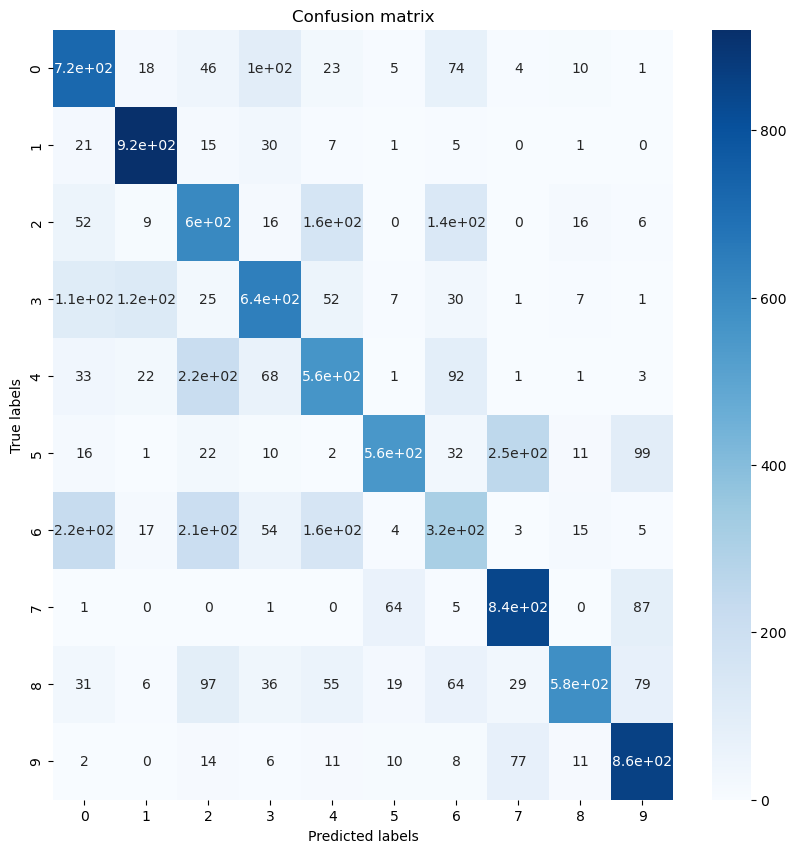

In [40]:
# build a confusion matrix with colors mapping


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(test_embeddingsT)
y_pred = y_pred.astype(int)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(test_labelsT, y_pred), annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()


In [39]:
test_labelsT

tensor([9, 2, 1,  ..., 8, 1, 5])

In [38]:
y_pred = knn.predict(test_embeddingsT)

In [41]:
train_embeddingsS.std(axis=0)

tensor([0.0067, 0.0097, 0.0045, 0.0145, 0.0036, 0.0034, 0.0061, 0.0015, 0.0080,
        0.0142, 0.0109, 0.0105, 0.0032, 0.0093, 0.0011, 0.0080, 0.0098, 0.0009,
        0.0076, 0.0076, 0.0099, 0.0012, 0.0063, 0.0052, 0.0111, 0.0094, 0.0042,
        0.0062, 0.0101, 0.0057, 0.0035, 0.0066, 0.0012, 0.0064, 0.0102, 0.0024,
        0.0055, 0.0066, 0.0066, 0.0058, 0.0008, 0.0092, 0.0106, 0.0035, 0.0065,
        0.0094, 0.0023, 0.0078, 0.0033, 0.0053, 0.0007, 0.0015, 0.0051, 0.0028,
        0.0004, 0.0014, 0.0012, 0.0033, 0.0078, 0.0011, 0.0082, 0.0080, 0.0040,
        0.0021, 0.0035, 0.0034, 0.0008, 0.0132, 0.0047, 0.0039, 0.0034, 0.0051,
        0.0019, 0.0013, 0.0137, 0.0106, 0.0007, 0.0106, 0.0011, 0.0056, 0.0065,
        0.0048, 0.0016, 0.0050, 0.0055, 0.0109, 0.0071, 0.0005, 0.0033, 0.0131,
        0.0089, 0.0010, 0.0068, 0.0015, 0.0157, 0.0015, 0.0102, 0.0121, 0.0028,
        0.0041])

In [42]:
train_embeddingsT.std(axis=0)

tensor([0.0069, 0.0103, 0.0066, 0.0120, 0.0043, 0.0023, 0.0066, 0.0012, 0.0075,
        0.0140, 0.0132, 0.0120, 0.0038, 0.0122, 0.0014, 0.0068, 0.0137, 0.0017,
        0.0068, 0.0080, 0.0076, 0.0019, 0.0069, 0.0064, 0.0114, 0.0080, 0.0046,
        0.0072, 0.0119, 0.0059, 0.0031, 0.0072, 0.0019, 0.0050, 0.0085, 0.0021,
        0.0057, 0.0062, 0.0065, 0.0076, 0.0017, 0.0083, 0.0090, 0.0013, 0.0051,
        0.0083, 0.0029, 0.0064, 0.0041, 0.0063, 0.0008, 0.0025, 0.0049, 0.0036,
        0.0010, 0.0015, 0.0011, 0.0006, 0.0092, 0.0014, 0.0093, 0.0075, 0.0010,
        0.0014, 0.0055, 0.0042, 0.0013, 0.0116, 0.0061, 0.0024, 0.0041, 0.0065,
        0.0010, 0.0015, 0.0154, 0.0106, 0.0012, 0.0134, 0.0035, 0.0073, 0.0076,
        0.0044, 0.0006, 0.0061, 0.0066, 0.0104, 0.0075, 0.0027, 0.0055, 0.0142,
        0.0101, 0.0009, 0.0079, 0.0046, 0.0184, 0.0010, 0.0093, 0.0162, 0.0041,
        0.0061])

# 5 - Understand the underlying mechanics : 

Try play with the rates:
- output dim ? (set @100 for now)
- learning rate (set @0.01 for now)
- update parameters for centering (m) and exponential moving average (lambda :l) for the loss
- number of layers in the model
- sharpening temperatures ? (set tpt=0.04, tps=0.1, for now)

batch size is not the most concern for now.
Implementing the small crops ?



Question I would like to know : what is the "average shift" per epoch in the model ? (take a point, and get embedding after each epoch, compute the difference (shift) and then see the average fro several points or others ?)